In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
from torch import nn
from pycocotools.coco import COCO
from pathlib import Path
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
import numpy as np
import skimage.io as io
from PIL import Image
import matplotlib.pyplot as plt
import os
import torchvision

cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
debug = False # used for verifying dimensional correctness

In [4]:
class SPADE(nn.Module):
  def __init__(self, norm_nc, label_nc):
    super().__init__()

    self.sync_batch_norm = nn.BatchNorm2d(norm_nc, affine=False)

    self.conv_0 = nn.Conv2d(label_nc, 128, kernel_size=3, padding=1)
    self.conv_gamma = nn.Conv2d(128, norm_nc, kernel_size=3, padding=1)
    self.conv_beta = nn.Conv2d(128, norm_nc, kernel_size=3, padding=1)

  def forward(self, x, segmap):
    x = self.sync_batch_norm(x)
    segmap = nn.functional.interpolate(segmap, size=x.size()[2:], mode='nearest')
    actv = nn.functional.relu(self.conv_0(segmap))
    x = x * self.conv_gamma(actv)
    x = x + self.conv_beta(actv)

    return x

In [5]:
class SPADE_ResBlk(nn.Module):
  def __init__(self, c_in, c_out, label_nc):
    super().__init__()
    self.learn_skip = (c_in != c_out)

    c_mid = min(c_in, c_out)

    self.spade_0 = SPADE(c_in, label_nc)
    self.conv_0 = nn.Conv2d(c_in, c_mid, kernel_size=3, padding=1)

    self.spade_1 = SPADE(c_mid, label_nc)
    self.conv_1 = nn.Conv2d(c_mid, c_out, kernel_size=3, padding=1)

    self.spade_skip = SPADE(c_in, label_nc)
    self.conv_skip = nn.Conv2d(c_in, c_out, kernel_size=1, bias=False)
    

  def forward(self, x, segmap):

    x_left = self.conv_0(nn.functional.relu(self.spade_0(x, segmap)))
    x_left = self.conv_1(nn.functional.relu(self.spade_1(x_left, segmap)))

    if self.learn_skip:
      x = self.conv_skip(nn.functional.relu(self.spade_skip(x, segmap)))

    return x_left + x

In [6]:
class generator(nn.Module):
  def __init__(self, label_nc):
    super().__init__()
    self.lin = nn.Linear(256, 16384)
    self.up = nn.Upsample(scale_factor=2)
    self.spade_res_0 = SPADE_ResBlk(1024, 1024, label_nc)
    self.spade_res_1 = SPADE_ResBlk(1024, 1024, label_nc)
    self.spade_res_2 = SPADE_ResBlk(1024, 1024, label_nc)
    self.spade_res_3 = SPADE_ResBlk(1024, 512, label_nc)
    self.spade_res_4 = SPADE_ResBlk(512, 256, label_nc)
    self.spade_res_5 = SPADE_ResBlk(256, 128, label_nc)
    self.spade_res_6 = SPADE_ResBlk(128, 64, label_nc)
    self.conv = nn.Conv2d(64, 3, kernel_size=3, padding=1)

  def forward(self, segmap, z=None):

    if z is None:
      z = torch.randn((segmap.size(0), 256), dtype=torch.float32)
    x = self.lin(z)
    x = torch.reshape(x, (-1, 1024, 4, 4))

    dx = self.spade_res_0(x, segmap)
    dx = self.up(dx)
    dx = self.spade_res_1(dx, segmap)
    dx = self.up(dx)
    dx = self.spade_res_2(dx, segmap)
    dx = self.up(dx)
    dx = self.spade_res_3(dx, segmap)
    dx = self.up(dx)
    dx = self.spade_res_4(dx, segmap)
    dx = self.up(dx)
    dx = self.spade_res_5(dx, segmap)
    dx = self.up(dx)
    dx = self.spade_res_6(dx, segmap)
    dx = self.up(dx)
    dx = self.conv(dx)
    dx = torch.tanh(dx)

    return dx

In [7]:
class encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_0 = nn.Conv2d(3, 64, 3, stride=2, padding=1)
    self.conv_1 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
    self.conv_2 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
    self.conv_3 = nn.Conv2d(256, 512, 3, stride=2, padding=1)
    self.conv_4 = nn.Conv2d(512, 512, 3, stride=2, padding=1)
    self.conv_5 = nn.Conv2d(512, 512, 3, stride=2, padding=1)
    self.linear_mu = nn.Linear(8192, 256)
    self.linear_var = nn.Linear(8192, 256)
    self.leaky_relu = nn.LeakyReLU(0.2)
    
  def forward(self, x):

    if x.size(2) != 256 or x.size(3) != 256:
      x = nn.functional.interpolate(x, size=(256, 256), mode='bilinear')

    dx = self.conv_0(x)
    dx = nn.functional.instance_norm(dx)
    dx = self.leaky_relu(dx)
    dx = self.conv_1(dx)
    dx = nn.functional.instance_norm(dx)
    dx = self.leaky_relu(dx)
    dx = self.conv_2(dx)
    dx = nn.functional.instance_norm(dx)
    dx = self.leaky_relu(dx)
    dx = self.conv_3(dx)
    dx = nn.functional.instance_norm(dx)
    dx = self.leaky_relu(dx)
    dx = self.conv_4(dx)
    dx = nn.functional.instance_norm(dx)
    dx = self.leaky_relu(dx)
    dx = self.conv_5(dx)
    dx = nn.functional.instance_norm(dx)
    dx = self.leaky_relu(dx)
    dx = torch.reshape(dx, (x.size(0), 8192))

    mu, logvar = self.linear_mu(dx), self.linear_var(dx)
    return mu, logvar

In [8]:
if debug:
  real = torch.rand((4, 3, 256, 256))
  enc = encoder()
  mu, logvar = enc(real)
  std = torch.exp(0.5 * logvar)
  eps = torch.randn_like(std)
  z = eps.mul(std) + mu
  gen = generator(16)
  seg = torch.rand((4, 16, 32, 32))
  op = gen(seg, z)
  print(op.shape)


In [9]:
class discriminator(nn.Module):
  def __init__(self, c_in):
    super().__init__()
    self.conv_0 = nn.Conv2d(c_in, 64, kernel_size=4, stride=2, padding=2)
    self.conv_1 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=2)
    self.conv_2 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=2)
    self.conv_3 = nn.Conv2d(256, 512, kernel_size=4, padding=2)
    self.conv_4 = nn.Conv2d(512, 1, kernel_size=4, padding=2)
    self.leaky_relu = nn.LeakyReLU(0.2)
    
  def forward(self, x):

    dx = self.conv_0(x)
    dx = self.leaky_relu(dx)
    dx = self.conv_1(dx)
    dx = self.leaky_relu(dx)
    dx = self.conv_2(dx)
    dx = self.leaky_relu(dx)
    dx = self.conv_3(dx)
    dx = self.leaky_relu(dx)
    dx = self.conv_4(dx)

    return dx

In [10]:
if debug:
  dis = discriminator(3)
  cat = torch.rand((4, 3, 256, 256))
  op = dis(cat)
  print(op.shape)

In [11]:
class KLDLoss(nn.Module):
    def forward(self, mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

class GANLoss(nn.Module):
    def __init__(self, target_real_label=1.0, target_fake_label=0.0, tensor=torch.FloatTensor):
      super().__init__()
      super(GANLoss, self).__init__()
      self.real_label = target_real_label
      self.fake_label = target_fake_label
      self.real_label_tensor = None
      self.fake_label_tensor = None
      self.zero_tensor = None
      self.Tensor = tensor

    def get_zero_tensor(self, input):
        if self.zero_tensor is None:
            self.zero_tensor = self.Tensor(1).fill_(0)
            self.zero_tensor.requires_grad_(False)
        return self.zero_tensor.expand_as(input)

    def __call__(self, input, target_is_real, for_discriminator=True):
      if for_discriminator:
        if target_is_real:
          minval = torch.min(input - 1, self.get_zero_tensor(input))
          loss = -torch.mean(minval)
        else:
          minval = torch.min(-input - 1, self.get_zero_tensor(input))
          loss = -torch.mean(minval)
      else:
        loss = -torch.mean(input)
      return loss

In [12]:
def save_network(net, label, epoch):
    save_filename = '%s_net_%s.pth' % (epoch, label)
    save_path = os.path.join(r"/content/drive/MyDrive/Colab Notebooks/ECE570/project", save_filename)
    torch.save(net.cpu().state_dict(), save_path)
    net.to(device)

In [13]:
class Pix2PixModel(nn.Module):
  def __init__(self, label_nc, c_in, use_vae=True, use_gpu=False):
    super().__init__()

    self.gen = generator(label_nc)
    self.dis = discriminator(c_in)
    self.enc = encoder()
    self.use_vae = use_vae
    self.use_gpu = use_gpu
    self.label_nc = label_nc

    self.FloatTensor = torch.cuda.FloatTensor if self.use_gpu else torch.FloatTensor
    self.ByteTensor = torch.cuda.ByteTensor if self.use_gpu else torch.ByteTensor

    self.KLDLoss = KLDLoss()
    self.criterionGAN = GANLoss(tensor=self.FloatTensor)
  
  def forward(self, data, mode):

    input_semantics, real_image = self.preprocess_input(data)

    if mode == 'generator':
      return self.generate(input_semantics, real_image)

    elif mode == 'discriminator':
      return self.compute_discriminator_loss(input_semantics, real_image)

    elif mode == 'encode_only':
      z, mu, logvar = self.encode_z(real_image)
      return mu, logvar

    elif mode == 'inference':
      with torch.no_grad():
        fake_image, _ = self.generate_fake(input_semantics, real_image)
      return fake_image

    else:
      raise ValueError("|mode| is invalid")
  
  def save(self, epoch):
    save_network(self.gen, 'G', epoch)
    save_network(self.dis, 'D', epoch)
    if self.use_vae:
        save_network(self.enc, 'E', epoch)

  def preprocess_input(self, data):
    data['label'] = data['label'].long()
    if self.use_gpu:
      data['label'] = data['label'].cuda()
      data['image'] = data['image'].cuda()

    label_map = data['label']
    bs, _, h, w = label_map.size()
    nc = self.label_nc
    input_label = self.FloatTensor(bs, nc, h, w).zero_()
    input_semantics = input_label.scatter_(1, label_map, 1.0)

    return input_semantics, data['image']

  def generate(self, input_semantics, real_image):
    G_losses = {}
    fake_image, KLD_loss = self.generate_fake(input_semantics, real_image)
    G_losses['KLD'] = KLD_loss

    pred_fake, pred_real = self.discriminate(input_semantics, fake_image, real_image)
    
    G_losses['GAN'] = self.criterionGAN(pred_fake, True, for_discriminator=False)
    
    return G_losses, fake_image

  def divide_pred(self, pred):
    fake = pred[:pred.size(0) // 2]
    real = pred[pred.size(0) // 2:]
    return fake, real


  def discriminate(self, input_semantics, fake_image, real_image):
    fake_concat = torch.cat([input_semantics, fake_image], dim=1)
    real_concat = torch.cat([input_semantics, real_image], dim=1)
    fake_and_real = torch.cat([fake_concat, real_concat], dim=0)
    discriminator_out = self.dis(fake_and_real)
    pred_fake, pred_real = self.divide_pred(discriminator_out)
    return pred_fake, pred_real

  def compute_discriminator_loss(self, input_semantics, real_image):
    D_losses = {}
    with torch.no_grad():
      fake_image, _ = self.generate_fake(input_semantics, real_image)
      if self.use_gpu:
        fake_image = fake_image.detach()
      fake_image.requires_grad_()

    pred_fake, pred_real = self.discriminate(input_semantics, fake_image, real_image)

    D_losses['D_Fake'] = self.criterionGAN(pred_fake, False, for_discriminator=True)
    D_losses['D_real'] = self.criterionGAN(pred_real, True, for_discriminator=True)

    return D_losses

  def generate_fake(self, input_semantics, real_image, compute_kld_loss=True):
    z, mu, logvar = self.encode_z(real_image)
    if compute_kld_loss:
      kld_loss = self.KLDLoss(mu, logvar) * 0.5
    else:
      kld_loss = None
    fake_image = self.gen(input_semantics, z=z)

    return fake_image, kld_loss
  
  def compute_generator_loss(self, input_semantics, real_image):
    G_losses = {}
    fake_image, KLD_loss = self.generate_fake(input_semantics, real_image, compute_kld_loss=self.use_vae)
    if self.opt.use_vae:
        G_losses['KLD'] = KLD_loss
    pred_fake, pred_real = self.discriminate(input_semantics, fake_image, real_image)
    G_losses['GAN'] = self.criterionGAN(pred_fake, True, for_discriminator=False)
    return G_losses, fake_image

  def create_optimizers(self, use_vae=True, isTrain=True, beta1=0.0, beta2=0.999, G_lr=0.0001, D_lr=0.0004):
    G_params = list(self.gen.parameters())
    if use_vae:
      G_params += list(self.enc.parameters())
    if isTrain:
      D_params = list(self.dis.parameters())

    optimizer_G = torch.optim.Adam(G_params, lr=G_lr, betas=(beta1, beta2))
    optimizer_D = torch.optim.Adam(D_params, lr=D_lr, betas=(beta1, beta2))

    return optimizer_G, optimizer_D
  
  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps.mul(std) + mu

  def encode_z(self, real_image):
    mu, logvar = self.enc(real_image)
    z = self.reparameterize(mu, logvar)
    return z, mu, logvar

In [14]:
class TrainPix2Pix():
  def __init__(self, label_nc, c_in):
    self.pix2pix_model = Pix2PixModel(label_nc, c_in, use_gpu=True)
    self.pix2pix_model.to(device)
    self.optimizer_G, self.optimizer_D = self.pix2pix_model.create_optimizers()
    self.g_losses = {}
    self.d_losses = {}

  def run_generator_one_step(self, data):
    self.optimizer_G.zero_grad()
    g_losses, generated = self.pix2pix_model(data, mode='generator')
    g_loss = sum(g_losses.values()).mean()
    g_loss.backward()
    self.optimizer_G.step()
    self.g_losses = g_losses
    self.generated = generated

  def run_discriminator_one_step(self, data):
    self.optimizer_D.zero_grad()
    d_losses = self.pix2pix_model(data, mode='discriminator')
    d_loss = sum(d_losses.values()).mean()
    d_loss.backward()
    self.optimizer_D.step()
    self.d_losses = d_losses
  
  def get_latest_losses(self):
    return {**self.g_losses, **self.d_losses}

  def update_lr(self):
    self.optimizer_G, self.optimizer_D = self.pix2pix_model.create_optimizers(G_lr=self.optimizer_G.param_groups[0]['lr'] /2, D_lr=self.optimizer_D.param_groups[0]['lr'] *2)

In [15]:
if debug:
  lbl = torch.rand((4, 12, 512, 512))
  img = torch.rand((4, 3, 512, 512))
  dt = {"label": lbl, "image": img}
  trn = TrainPix2Pix(12, 15)
  trn.run_generator_one_step(dt)
  print("one step gen done")
  trn.run_discriminator_one_step(dt)
  print("one step disc done")

In [16]:
ROOT_PATH = Path("/content/drive/MyDrive/Colab Notebooks/ECE570/project/COCOdataset2017")
IMAGE_SIZE = (512, 512)

train_annotations = COCO(ROOT_PATH / "annotations/stuff_train2017.json")
valid_annotations = COCO(ROOT_PATH / "annotations/stuff_val2017.json")

cat_ids = train_annotations.getCatIds(supNms=[])
train_img_ids = []
for cat in cat_ids:
    train_img_ids.extend(train_annotations.getImgIds(catIds=cat))
    
train_img_ids = list(set(train_img_ids))
print(f"Number of training images: {len(train_img_ids)}")

valid_img_ids = []
for cat in cat_ids:
    valid_img_ids.extend(valid_annotations.getImgIds(catIds=cat))
    
valid_img_ids = list(set(valid_img_ids))
print(f"Number of validation images: {len(valid_img_ids)}")

loading annotations into memory...
Done (t=0.86s)
creating index...
index created!
loading annotations into memory...
Done (t=1.14s)
creating index...
index created!
Number of training images: 5000
Number of validation images: 5000


In [17]:
BATCH_SIZE = 4

class myDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, img_ids, cat_ids, root_path, transform=None):
        super().__init__()
        self.annotations = annotations
        self.img_data = annotations.loadImgs(img_ids)
        self.cat_ids = cat_ids
        self.files = [str(root_path / img["file_name"]) for img in self.img_data]
        self.transform = transform
        
    def __len__(self) -> int:
        return len(self.files)
    
    def __getitem__(self, i):
        ann_ids = self.annotations.getAnnIds(
            imgIds=self.img_data[i]['id'], 
            catIds=self.cat_ids, 
            iscrowd=None
        )
        anns = self.annotations.loadAnns(ann_ids)
        mask = torch.FloatTensor(np.max(np.stack([self.annotations.annToMask(ann) * ann["category_id"] 
                                                 for ann in anns]), axis=0)).unsqueeze(0)
        
        initial_transform = torchvision.transforms.Compose([torchvision.transforms.ToPILImage()])
        mask = initial_transform(mask)

        img = Image.open(self.files[i])
        img = img.convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
            mask = self.transform(mask) * 255.0
        
        return {"image":img, "label":mask}


transform = torchvision.transforms.Compose([torchvision.transforms.Resize(IMAGE_SIZE, interpolation=torchvision.transforms.InterpolationMode.NEAREST), torchvision.transforms.ToTensor()])

train_data = myDataset(train_annotations, train_img_ids, cat_ids, ROOT_PATH / "images/train2017", transform)
valid_data = myDataset(valid_annotations, valid_img_ids, cat_ids, ROOT_PATH / "images/val2017", transform)

train_dataloader = DataLoader(train_data, BATCH_SIZE, shuffle=True)

val_dataloader = DataLoader(valid_data, 1, shuffle=False)

In [18]:
# observe dataset
if debug:
  dat = train_data[24]
  img, mask = dat["image"], dat["label"]
  plt.figure(figsize=(6, 12))
  plt.subplot(211)
  plt.imshow(torchvision.transforms.functional.to_pil_image(img))
  plt.subplot(212)
  plt.imshow(mask.squeeze())
  plt.show()

In [19]:
losses = []
trainer = TrainPix2Pix(256, 259)
num_epochs = 2
D_steps_per_G = 2
for epoch in range(num_epochs):
  for i, data_i in enumerate(train_dataloader):

    if i % D_steps_per_G == 0:
        trainer.run_generator_one_step(data_i)
    trainer.run_discriminator_one_step(data_i)

    if i % 4 == 0:
      l = trainer.get_latest_losses()
      print(f"epoch {epoch}, batch_idx {i} ", l)
      losses.append((l["KLD"].item(), l["GAN"].item(), l["D_Fake"].item(), l["D_real"].item()))
    if i >= 250: # limit images to 1000
      break
  trainer.pix2pix_model.save(epoch+1)
  trainer.update_lr()


epoch 0, batch_idx 0  {'KLD': tensor(68.1984, device='cuda:0', grad_fn=<MulBackward0>), 'GAN': tensor(-0.0004, device='cuda:0', grad_fn=<NegBackward0>), 'D_Fake': tensor(1.0004, device='cuda:0', grad_fn=<NegBackward0>), 'D_real': tensor(0.9992, device='cuda:0', grad_fn=<NegBackward0>)}
epoch 0, batch_idx 4  {'KLD': tensor(56.8812, device='cuda:0', grad_fn=<MulBackward0>), 'GAN': tensor(1.1543, device='cuda:0', grad_fn=<NegBackward0>), 'D_Fake': tensor(0.9009, device='cuda:0', grad_fn=<NegBackward0>), 'D_real': tensor(0.2344, device='cuda:0', grad_fn=<NegBackward0>)}
epoch 0, batch_idx 8  {'KLD': tensor(52.7383, device='cuda:0', grad_fn=<MulBackward0>), 'GAN': tensor(2.1644, device='cuda:0', grad_fn=<NegBackward0>), 'D_Fake': tensor(0.4285, device='cuda:0', grad_fn=<NegBackward0>), 'D_real': tensor(0.1168, device='cuda:0', grad_fn=<NegBackward0>)}
epoch 0, batch_idx 12  {'KLD': tensor(53.8705, device='cuda:0', grad_fn=<MulBackward0>), 'GAN': tensor(1.2372, device='cuda:0', grad_fn=<NegB

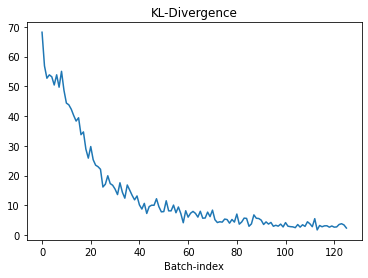

In [20]:
kld = [x[0] for x in losses]
gan = [x[1] for x in losses]
d_fake = [x[2] for x in losses]
d_real = [x[3] for x in losses]
plt.plot(kld)
plt.title("KL-Divergence")
plt.xlabel("Batch-index")
plt.show()

In [21]:
gan = [g for g in gan if g < 10]
d_real = [dr for dr in d_real if dr < 10]

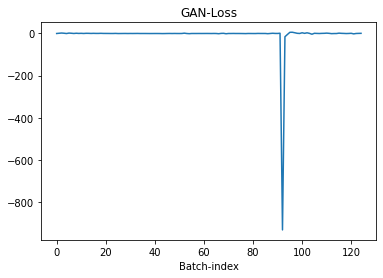

In [22]:
plt.plot(gan)
plt.title("GAN-Loss")
plt.xlabel("Batch-index")
plt.show()

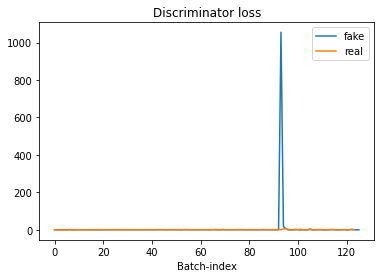

In [23]:
plt.plot(d_fake)
plt.plot(d_real)
plt.title("Discriminator loss")
plt.xlabel("Batch-index")
plt.legend(["fake", "real"])
plt.show()

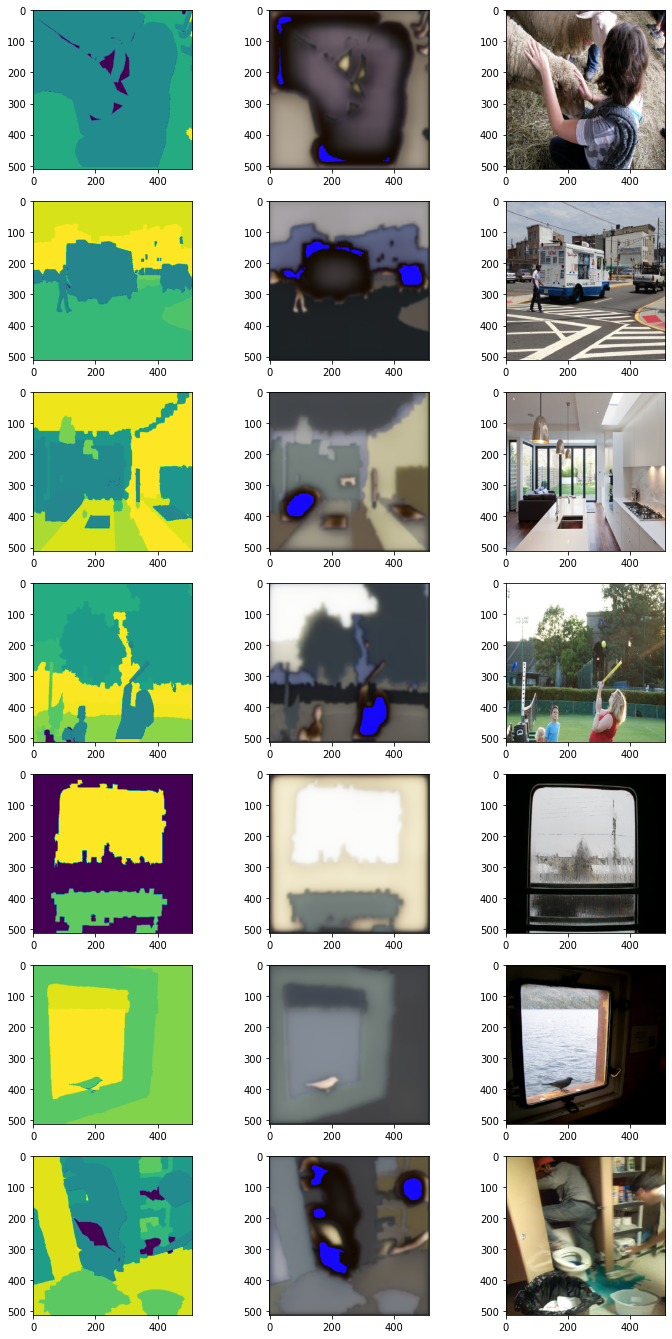

In [24]:
model = trainer.pix2pix_model
model.eval()
model.to(device)

plt.figure(figsize=(12, 24))

for i, data_i in enumerate(val_dataloader):
    generated = model(data_i, mode='inference')

    plt.subplot(7, 3, 3*i+1)
    plt.imshow(data_i["label"].cpu().squeeze())
    plt.subplot(7, 3, 3*i+2)
    plt.imshow(torchvision.transforms.functional.to_pil_image(torch.reshape(generated, (3, 512, 512))))
    plt.subplot(7, 3, 3*i+3)
    plt.imshow(torchvision.transforms.functional.to_pil_image(torch.reshape(data_i["image"], (3, 512, 512))))
    
    if i > 5:
      break
plt.show()